# Групповое задание по теме «Классификация текста»
Команда 2

# Описание датасета
### Общая информация

https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews/code

Коллекция рецензий пользователей на фильмы с сайта **kinopoisk.ru**:
- положительных: 87101;
- отрицательных: 19804;
- нейтральных: 24678;
- всего: 131583.

Каждый отзыв хранится в отдельном текстовом файле (.txt). Основное содержимое файла — текст отзыва. Нет явной структуры вроде CSV-файла, просто чистый текст. Папки разделены по тональности отзывов:
neg/ — негативные отзывы (19.8 тыс. файлов);
neu/ — нейтральные отзывы (24.7 тыс. файлов);
pos/ — положительные отзывы (87.1 тыс. файлов).

**Вес файлов**: 539.31 МБ.

**Метод разметки**: пользователи сайта самостоятельно указывают категорию отзыва.


Разметка в целом соответствует содержанию. Пример: «Это похоже на бред сумасшедшего…» отрицательный отзыв, а «В целом идея хорошая, и три сезона по 10 серий не такие уж длинные. Но мне показалось, что сюжет подтянут… 6 из 10.» как нейтральный.


### Гипотеза
Наличие нейтральных отзывов в датасете фильмов снижает точность модели классификации отзывов по тональности (положительные и отрицательные), поскольку нейтральные тексты имею размытые признаки и могут "размывать" границы между положительными и отрицательными классами.

# Загрузка датасета **Kinopoisk's movies reviews**


## Подключение Kaggle и установка файлов датасета

In [1]:
# install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
# create a kaggle folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#!/bin/bash
!kaggle datasets download mikhailklemin/kinopoisks-movies-reviews

Dataset URL: https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews
License(s): unknown
 66% 147M/222M [00:00<00:00, 1.53GB/s]
100% 222M/222M [00:00<00:00, 953MB/s] 


In [5]:
!unzip kinopoisks-movies-reviews.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/pos/88738-11.txt  
  inflating: dataset/pos/88738-12.txt  
  inflating: dataset/pos/88738-13.txt  
  inflating: dataset/pos/88738-14.txt  
  inflating: dataset/pos/88738-15.txt  
  inflating: dataset/pos/88738-2.txt  
  inflating: dataset/pos/88738-3.txt  
  inflating: dataset/pos/88738-4.txt  
  inflating: dataset/pos/88738-6.txt  
  inflating: dataset/pos/88738-7.txt  
  inflating: dataset/pos/88749-0.txt  
  inflating: dataset/pos/88749-1.txt  
  inflating: dataset/pos/88749-2.txt  
  inflating: dataset/pos/887519-0.txt  
  inflating: dataset/pos/887519-1.txt  
  inflating: dataset/pos/887519-2.txt  
  inflating: dataset/pos/887519-3.txt  
  inflating: dataset/pos/887519-4.txt  
  inflating: dataset/pos/887519-5.txt  
  inflating: dataset/pos/887519-6.txt  
  inflating: dataset/pos/887519-7.txt  
  inflating: dataset/pos/887535-0.txt  
  inflating: dataset/pos/887535-1.txt  
  inflating: dataset

## Подготовка датасета

In [6]:
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 105.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import os
import re

import numpy as np
import pandas as pd

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

In [8]:
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [9]:
nlp = spacy.load("ru_core_news_sm")

# Включить если используется GPU
# spacy.require_gpu()
# spacy.prefer_gpu()

### Функции преобразования

Предварительная подготовка данных включает в себя этапы:
- преобразование текста;
- удаление пунктуации;
- удаление пробельных символов;
- удаление стоп-слов;
- лемматизация.

В блоке ниже представлены функции для предобработки текста, операция лемматизации является наиболее ресурсоёмкой.

In [10]:
def format_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    # text = re.sub(r"[^А-Яа-яA-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    text = re.sub(r"[Ёё]", "е", text)
    text = re.sub(r"[\t\n]", "", text)
    text = re.sub(r"[^А-Яа-яa-zA-Z]", " ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stop_words(text):
  tokens = text.split()
  tokens = [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

def lemmatize(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])

def preprocess_text(text):
  text = format_text(text)
  # text = remove_stop_words(text)
  # text = lemmatize(text) # Включить если используется GPU, занимает много времени.
  return text

### Константы проекта

In [13]:
DATASET_BASE = './dataset'
RANDOM_STATE = 42

N_SAMPLES_PER_CLASS = 20000  # сколько максимально примеров брать из каждого класса

In [14]:
df = pd.DataFrame(columns=['text', 'label'])
labels = os.listdir(DATASET_BASE)
print("Найдены классы:", labels)

for label in labels:
    folder = os.path.join(DATASET_BASE, label)
    files = os.listdir(folder)

    np.random.shuffle(files)

    n_to_take = min(len(files), N_SAMPLES_PER_CLASS)
    selected_files = np.random.choice(files, n_to_take, replace=False)

    for filename in selected_files:
        file_path = os.path.join(folder, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            raw_text = f.read().strip()
            processed_text = preprocess_text(raw_text)
            df.loc[len(df)] = [processed_text, label]

df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print("Финальный размер датасета:", df.shape)

Найдены классы: ['neu', 'pos', 'neg']
Финальный размер датасета: (59827, 2)


In [15]:
df.head(5)

,text,label
0,эту цветастую историю я помню с детства в гунд...,neu
1,ни жалко ублюдков ни капли ради того чтобы зав...,neu
2,начну с того что никогда не являлся поклоннико...,pos
3,не все то что бабуинически смешно есть комедия...,neg
4,уже во время просмотра мне стало ясно что поло...,neg


Количество уникальных классов

In [16]:
df['label'].value_counts()

,count
label,
neu,20000
pos,20000
neg,19827


Проверка на пропуски

In [17]:
df.isnull().sum()

,0
text,0
label,0


Проверка на дубликаты

In [18]:
df['text'].duplicated().sum()

np.int64(46)

In [19]:
df.drop_duplicates(subset='text', inplace=True)
df['text'].duplicated().sum()

np.int64(0)

Средняя длина текста, распределение длин

In [20]:
df['text'].str.split().str.len().describe()

,text
count,59781.000000
mean,334.166156
std,199.325254
min,9.000000
25%,190.000000
50%,288.000000
75%,430.000000
max,1732.000000


Большинство текстов относительно короткие (около 200 слов), но есть и как очень длинные (около 1000 слов), так и очень короткие (менее 10).

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

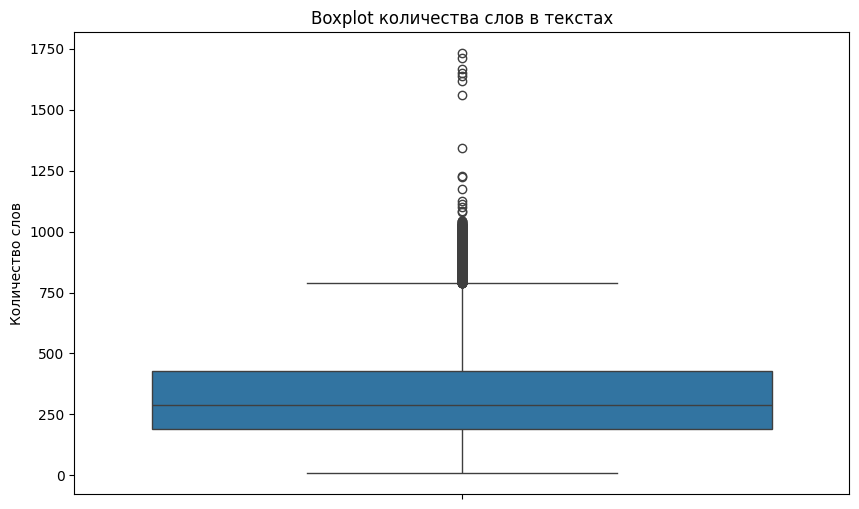

In [22]:
df['word_count'] = df['text'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='word_count')
plt.title('Boxplot количества слов в текстах')
plt.ylabel('Количество слов')
plt.show()

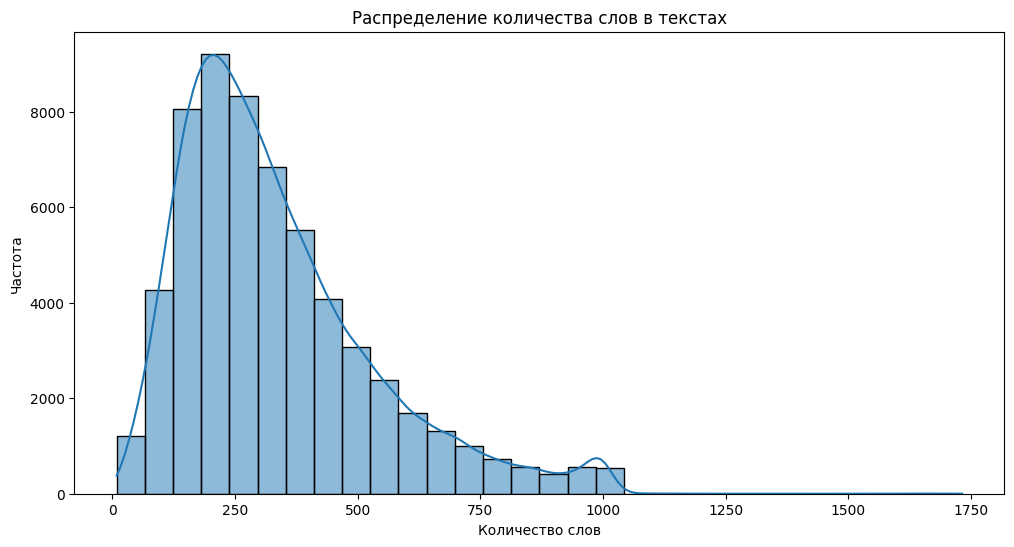

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', bins=30, kde=True)
plt.title('Распределение количества слов в текстах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

Для большего единообразия обучающей выборки удалим слишком длинные и слишком короткие тексты (более 400 и менее 50 слов)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [25]:
mask_to_remove = (X_train.str.split().str.len() < 50) | (X_train.str.split().str.len() > 400)

X_train_cleaned = X_train[~mask_to_remove]
y_train_cleaned = y_train[~mask_to_remove]

print(f"Было записей: {len(X_train)}")
print(f"Осталось записей: {len(X_train_cleaned)}")

Было записей: 47824
Осталось записей: 33555


In [26]:
X_train_cleaned.head()

,text
33304,я конечно понимаю снимали комедию и авторам хо...
15156,обожаю кристиана клавье и люблю филиппа де шов...
12292,увидим что фильм собирает не плохую кассу я ож...
47893,джэйсон стэтхэм постепенно становится заложник...
39469,почему после выхода двух прекрасных мачете и п...


# Классификация по 3 категориям

In [27]:
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accurancy: {acc:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=labels)
    disp.plot()
    # print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

In [28]:
tfidf_vectorizer = TfidfVectorizer() # ngram_range=(1,2)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_cleaned)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Для классификации текстов использовался метод TF-IDF для преобразования текста в числовые признаки. В качестве моделей применялись линейные классификаторы (Logistic Regression, LinearSVC) и Multinomial Naive Bayes, так как TF-IDF улучшает качество работы простых моделей.

Accurancy: 0.6385


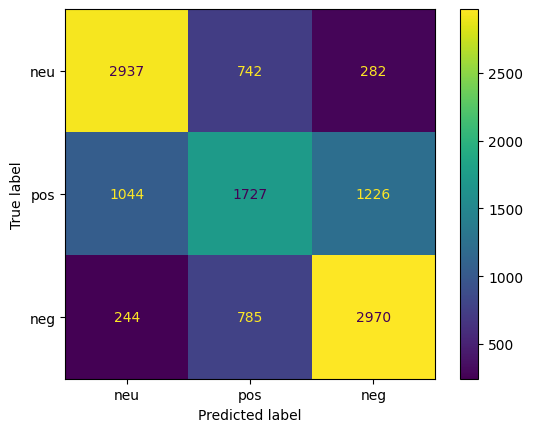

In [29]:
svm_clf = LinearSVC(C=1.0)
evaluate_model(svm_clf, X_train_tfidf, X_test_tfidf, y_train_cleaned, y_test, "LinearSVC (TF-IDF)")

Accurancy: 0.6302


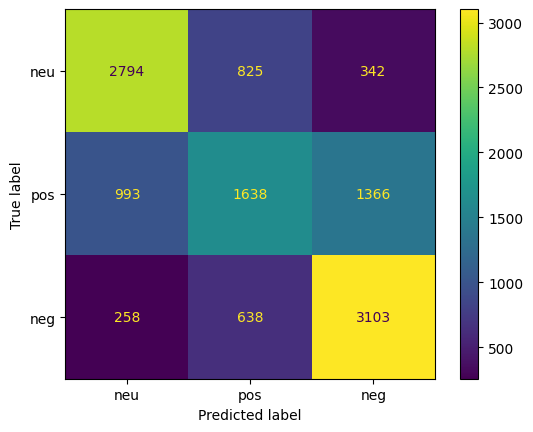

In [30]:
mnb = MultinomialNB()
evaluate_model(mnb, X_train_tfidf, X_test_tfidf, y_train_cleaned, y_test, "MultinomialNB (TF-IDF)")

Accurancy: 0.6588


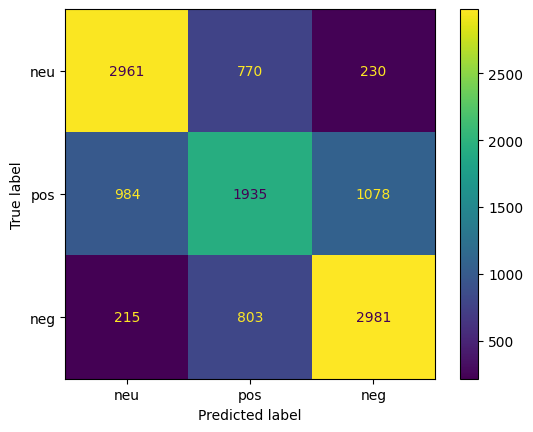

In [31]:
logreg = LogisticRegression(max_iter=1000)
evaluate_model(logreg, X_train_tfidf, X_test_tfidf, y_train_cleaned, y_test, "LogReg (TF-IDF)")

Создадим ансамбль из базовых методов. Веса подберем при помощи Optuna.

In [32]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.7 MB/s eta 0:00:00


In [33]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import numpy as np

def objective(trial):
    w1 = trial.suggest_float("w1", 0.5, 5)
    w2 = trial.suggest_float("w2", 0.5, 5)
    w3 = trial.suggest_float("w3", 0.5, 5)

    clf = VotingClassifier(
        estimators=[('svm', svm_clf), ('mnb', mnb), ('logreg', logreg)],
        voting='hard',
        weights=[w1, w2, w3]
    )

    score = cross_val_score(clf, X_train_tfidf, y_train_cleaned, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Лучшие веса:", [study.best_params['w1'], study.best_params['w2'], study.best_params['w3']])
print("Лучший score:", study.best_value)

[I 2025-09-30 15:54:47,909] A new study created in memory with name: no-name-66180c32-3173-4551-b47f-07e8e2e10c53
[I 2025-09-30 15:57:04,411] Trial 0 finished with value: 0.6555803904038147 and parameters: {'w1': 3.183395443006045, 'w2': 1.8663606769524494, 'w3': 4.377755769457913}. Best is trial 0 with value: 0.6555803904038147.
[I 2025-09-30 15:58:57,460] Trial 1 finished with value: 0.6419013559827149 and parameters: {'w1': 4.7665707397994685, 'w2': 1.1339834598927365, 'w3': 1.1214301610772428}. Best is trial 0 with value: 0.6555803904038147.
[I 2025-09-30 16:00:49,002] Trial 2 finished with value: 0.6555803904038147 and parameters: {'w1': 4.077998534243706, 'w2': 2.558349316463749, 'w3': 4.905531246064305}. Best is trial 0 with value: 0.6555803904038147.
[I 2025-09-30 16:02:40,160] Trial 3 finished with value: 0.6542095067799136 and parameters: {'w1': 4.299380375540238, 'w2': 4.835105282228141, 'w3': 1.3689599583498844}. Best is trial 0 with value: 0.6555803904038147.
[I 2025-09-30

Лучшие веса: [3.183395443006045, 1.8663606769524494, 4.377755769457913]
Лучший score: 0.6555803904038147


Ансамбль не дал существенного прироста метрик по сравнению с метриками лучшей из трех используемых моделей (logreg).

# Бинарная классификация

Проверим гипотезу: наличие нейтральных отзывов в датасете фильмов снижает точность моделей.

In [34]:
labels = ['neg', 'pos']
df = df[df['label'].isin(labels)]

df['label'].value_counts()

,count
label,
pos,19996
neg,19803


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [36]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Accurancy: 0.9009


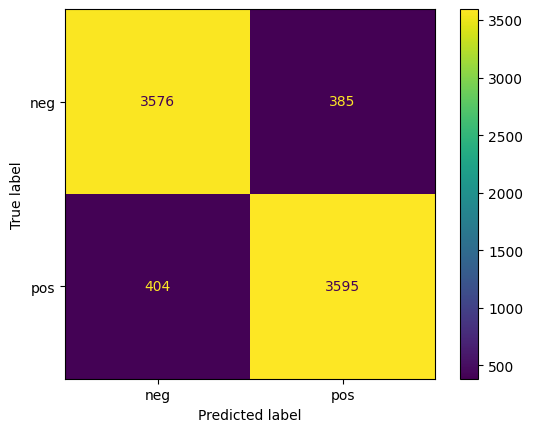

In [37]:
svm_clf = LinearSVC(C=1.0, class_weight='balanced')
evaluate_model(svm_clf, X_train_tfidf, X_test_tfidf, y_train, y_test, "LinearSVC (TF-IDF)")

Accurancy: 0.8629


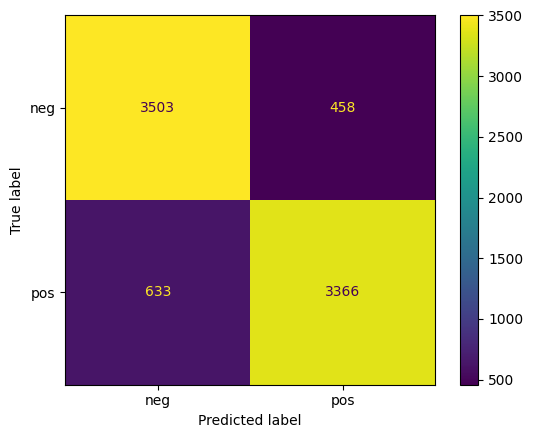

In [38]:
mnb = MultinomialNB()
evaluate_model(mnb, X_train_tfidf, X_test_tfidf, y_train, y_test, "MultinomialNB (TF-IDF)")

Accurancy: 0.8902


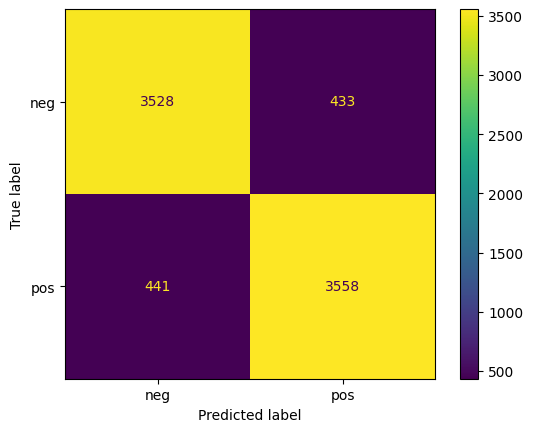

In [39]:
logreg = LogisticRegression(max_iter=1000)
evaluate_model(logreg, X_train_tfidf, X_test_tfidf, y_train, y_test, "LogReg (TF-IDF)")